# Chapter 6 Assignment- Decision Tree

In [4]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances? 

The depth of a decision tree is determined by  O(log2(m)), there for the approximate depth of a decision tree model trained on a training set with one million instances is 
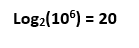

Approximately 20 ( a bit more since the tree will generally not be perfectly well balanced).

# 2. Is a node’s Gini impurity generally lower or greater than its parent’s? Is it gener‐ ally lower/greater, or always lower/greater? 

The node's Gini impurity is generally lower that the parents and this is because of the CART training algorithm's cost function. It mimimizes the Gini impurity of the node by splitting each parent node thereby decreasing the weighted sum of the nodes impurities.


# 3. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth? 

To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training this is called regularization. 

###### Hence, reducing max_depth will regularize the model and thus reduce the risk of overfitting


# 4. If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features? 

One of the many qualities of Decision Trees is that they require
very little data preparation. In fact, they don’t require feature scal‐
ing or centering at all.

So scaling would be a waste of time, if it is underfitting, increase the hyperparameters


# 5. If it takes one hour to train a Decision Tree on a training set containing 1 million instances, roughly how much time will it take to train another Decision Tree on a training set containing 10 million instances? 

The computational complexity of training a Decision Tree is O(n × m log(m)). So if  the training set is multiplied by 10, then the  training time will be multiplied by K. To determine the value of K, divide the complexity of both

K = (n × 10m × log(10m)) / (n × m × log(m)) = 10 × log(10m) / log(m). 
for 10 million instances i.e., m = 10^6, 

##### then K ≈ 11.7, so you can expect the training time to be roughly 11.7 hours.

# 6. If your training set contains 100,000 instances, will setting presort=True speed up training? 

When training with less than a few thousand (3,000 instances), presorting can speed up training  (set presort=True), 

##### but if the training instances are large, presorting would slow down training considerably 

# 7. Exercise: train and fine-tune a Decision Tree for the moons dataset.

#### a. Generate a moons dataset using make_moons(n_samples=10000, noise=0.4).

In [1]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

#### b. Split it into a training set and a test set using train_test_split().

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###### c. Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. Hint: try various values for max_leaf_nodes.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)


Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)


##### d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.


In [9]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8. Exercise: Grow a forest.

##### a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's ShuffleSplit class for this.

In [10]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

##### b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [11]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

#### c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's mode() function for this). This gives you majority-vote predictions over the test set.

In [12]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [13]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

##### d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [15]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872